In [6]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow_asr.configs.config import SpeechConfig
from tensorflow_asr.featurizers import speech_featurizers
from tensorflow_asr.utils import env_util

env_util.setup_environment()

speech_conf = SpeechConfig({
    "sample_rate": 16000,
    "frame_ms": 25,
    "stride_ms": 10,
    "feature_type": "log_mel_spectrogram",
    "preemphasis": 0.97,
    "normalize_signal": False,
    "normalize_feature": False,
    "normalize_per_frame": False,
    "num_feature_bins": 80,
    "compute_energy": True,
    "use_natural_log": False,
    "use_librosa_like_stft": True,
    "fft_overdrive": False,
    "output_floor": 1e-10,
    "lower_edge_hertz": 0.0,
    "upper_edge_hertz": 8000.0,
})
signal = speech_featurizers.read_raw_audio("./test.flac", speech_conf.sample_rate)

signal length: 143040
(80, 891)


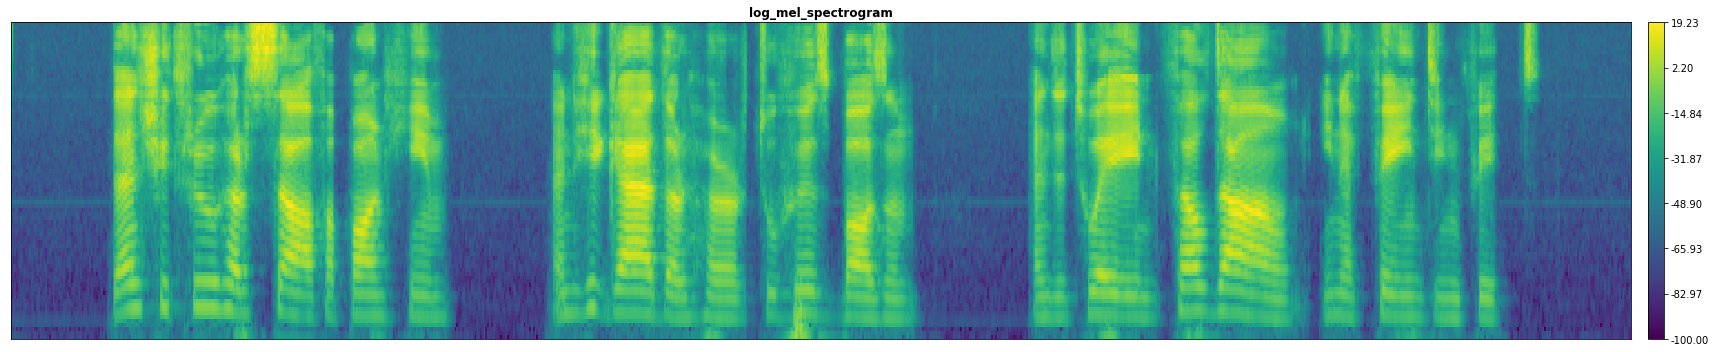

24.177223
-38.076122
With chunk size: 1040 and nfft: 512
(80, 891)


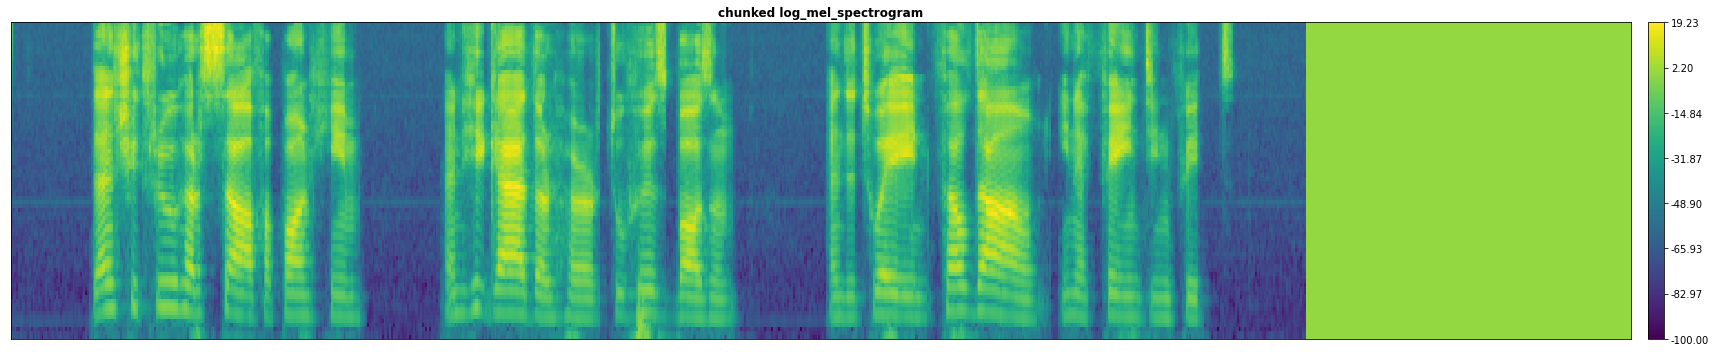

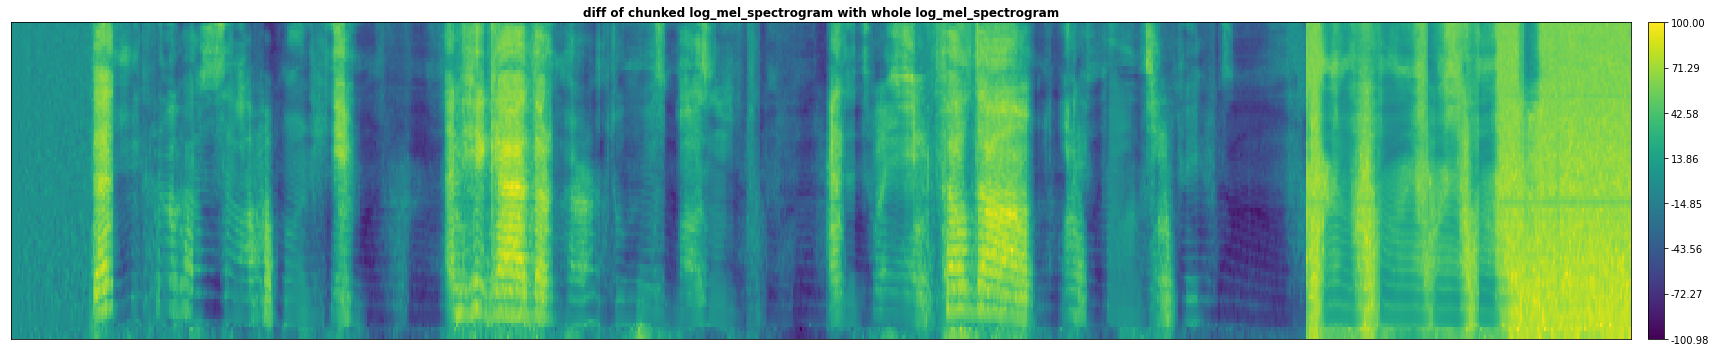

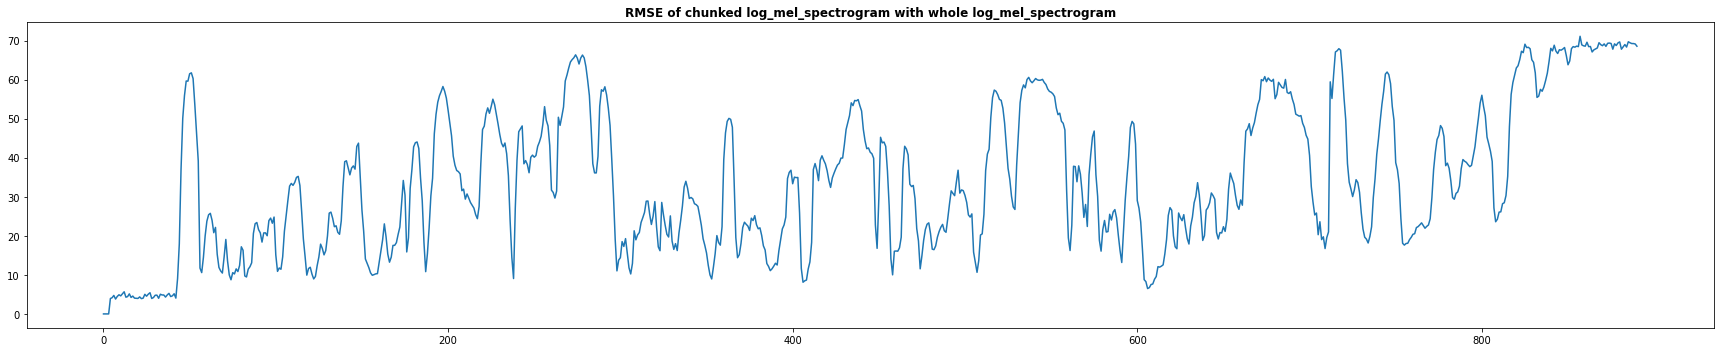

In [7]:
print(f"signal length: {len(signal)}")
sf = speech_featurizers.SpeechFeaturizer(speech_conf)
ft = sf.extract(signal)
ft = tf.squeeze(ft, axis=-1)
ft = ft.numpy().T
print(ft.shape)

plt.figure(figsize=(24, 5))
ax = plt.gca()
ax.set_title("log_mel_spectrogram", fontweight="bold")
librosa.display.specshow(ft, cmap="viridis")
v1 = np.linspace(ft.min(), ft.max(), 8, endpoint=True)
plt.colorbar(pad=0.01, fraction=0.02, ax=ax, format="%.2f", ticks=v1)
plt.tight_layout()
plt.show()

print(np.std(ft))
print(np.mean(ft))

nframes = 5
chunk_size = (nframes - 1) * sf.speech_config.frame_step + sf.speech_config.frame_length
stride = nframes * sf.speech_config.frame_step
print(f"With chunk size: {chunk_size} and nfft: {sf.nfft}")
signal_length = len(signal)
all_ft = None
for i in range(int(np.ceil((signal_length - chunk_size) / stride))): # this ensure the fft shape of chunked signal is the same with whole signal
    chunk = signal[i * stride: i*stride + chunk_size]
    # cft = sf.power_to_db(sf.stft(chunk))
    cft = sf.extract(chunk)
    cft = tf.squeeze(cft, axis=-1)
    cft = cft.numpy()
    if all_ft is None:
        all_ft = cft
    else:
        all_ft = np.concatenate([all_ft, cft], axis=0)
all_ft = all_ft.T
all_ft = np.pad(all_ft, [[0, 0], [0, ft.shape[-1] - all_ft.shape[-1]]])
print(all_ft.shape)

plt.figure(figsize=(24, 5))
ax = plt.gca()
ax.set_title(f"chunked log_mel_spectrogram", fontweight="bold")
librosa.display.specshow(all_ft, cmap="viridis")
v1 = np.linspace(all_ft.min(), all_ft.max(), 8, endpoint=True)
plt.colorbar(pad=0.01, fraction=0.02, ax=ax, format="%.2f", ticks=v1)
plt.tight_layout()
plt.show()

dft = all_ft - ft

plt.figure(figsize=(24, 5))
ax = plt.gca()
ax.set_title(f"diff of chunked log_mel_spectrogram with whole log_mel_spectrogram", fontweight="bold")
librosa.display.specshow(dft, cmap="viridis")
v1 = np.linspace(dft.min(), dft.max(), 8, endpoint=True)
plt.colorbar(pad=0.01, fraction=0.02, ax=ax, format="%.2f", ticks=v1)
plt.tight_layout()
plt.show()

plt.figure(figsize=(24, 5))
ax = plt.gca()
ax.set_title(f"RMSE of chunked log_mel_spectrogram with whole log_mel_spectrogram", fontweight="bold")
plt.plot(np.sqrt(np.mean(dft ** 2, axis=0)))
plt.tight_layout()
plt.show()